# Spherical Gaussian experiment (2D)

## Setup

In [7]:
import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset
import logging


sys.path.append("../../")
import manifold_flow as mf
from manifold_flow import transforms, utils, flows, distributions, training
from manifold_flow import nn as nn_
from experiments.simulators.spherical_simulator import SphericalGaussianSimulator

%matplotlib inline

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.DEBUG,
)
logger = logging.getLogger(__name__)
# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "experiments" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)


### Settings

In [8]:
epochs = 20
n_train = 100000
epsilon = 0.05

### Data

In [3]:
simulator = SphericalGaussianSimulator(latent_dim=1, data_dim=2, epsilon=epsilon)
x = simulator.sample(n_train)
x_tensor = torch.from_numpy(x)
train_dataset = TensorDataset(x_tensor, x_tensor)

17:25 experiments.simulators.spheric DEBUG   Evaluating true log density for x = [-1.4 -1.4]
17:25 experiments.simulators.spheric DEBUG   Latent variables: z_phi = [3.92699082], z_eps = [0.97989899]
17:25 experiments.simulators.spheric DEBUG   Beginning iteration


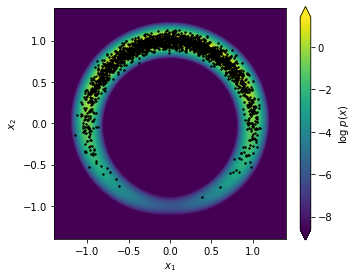

In [4]:
res = 1000
x_range = np.linspace(-1.4,1.4,res)
y_range = np.linspace(-1.4,1.4,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
logp_grid = simulator.log_density(x_grid, precise=True).reshape((res, res))
logp_grid[~np.isfinite(logp_grid)] = -1000000.

zmin, zmax = np.max(logp_grid) - 10, np.max(logp_grid)
fig = plt.figure(figsize=(5,4))
ax = plt.gca()

pcm = plt.imshow(
    np.clip(logp_grid, zmin, zmax),
    extent=(-1.4,1.4,-1.4,1.4),
    origin="lower",
    cmap="viridis", norm=matplotlib.colors.Normalize(zmin, zmax),
    interpolation='nearest'
)
cb = plt.colorbar(pcm, extend="both")
plt.scatter(x[::50,0], x[::50,1], s=2., c="black", alpha=1.)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
cb.set_label("$\log \; p(x)$")
plt.tight_layout()

plt.savefig("spherical_gaussian_2d_data.pdf", dpi=500)

In [5]:
pixel_size = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])

np.sum(np.exp(logp_grid) * pixel_size)

1.0025000000000504

In [6]:
n_mc = 1000000
size_mc = 2.5
x_mc = - size_mc / 2 + size_mc * np.random.uniform(size=2*n_mc).reshape((n_mc, 2))

logp_mc = simulator.log_density(x_mc)

np.sum(np.exp(logp_mc) / n_mc * size_mc**2)

17:25 experiments.simulators.spheric DEBUG   Evaluating true log density for x = [ 1.01953963 -0.23152246]
17:25 experiments.simulators.spheric DEBUG   Latent variables: z_phi = [6.05988694], z_eps = [0.04549687]
17:25 experiments.simulators.spheric DEBUG   Beginning iteration


1.0102442004649879

## Set up models

### Manifold flow

In [5]:
outer_trf = flows.vector_transforms.create_transform(
    dim=2,
    flow_steps=3,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    hidden_features=10,
    num_transform_blocks=3,
    dropout_probability=0.25,
    use_batch_norm=False
)
inner_trf = transforms.ElementwisePiecewiseRationalQuadraticTransform()

mf = flows.manifold_flow.ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    inner_transform=inner_trf,
    outer_transform=outer_trf,
)

10:48 manifold_flow.flows.manifold_f DEBUG   Set up projection from vector with dimension 2 to vector with dimension 1
10:48 manifold_flow.flows.manifold_f DEBUG   Created manifold flow with 0.0 M parameters (0.0 M trainable) with an estimated size of 0.0 GB


In [6]:
trainer = training.trainer.ManifoldFlowTrainer(mf)
trainer.train(
    train_dataset,
    [training.losses.mse, training.losses.nll],
    loss_weights=[100., 0.001],
    epochs=epochs // 2,
)
trainer.train(
    train_dataset,
    [training.losses.mse, training.losses.nll],
    loss_weights=[0., 1.],
    epochs=epochs // 2,
    parameters=mf.inner_transform.parameters()
)

10:48 manifold_flow.training.trainer INFO    Training on CPU with single precision
10:48 manifold_flow.training.trainer DEBUG   Initialising training data
10:48 manifold_flow.training.trainer DEBUG   Setting up optimizer
10:48 manifold_flow.training.trainer DEBUG   Setting up LR scheduler
10:48 manifold_flow.training.trainer DEBUG   Using early stopping with infinite patience
10:48 manifold_flow.training.trainer DEBUG   Will print training progress every 1 epochs
10:48 manifold_flow.training.trainer DEBUG   Beginning main training loop
10:48 manifold_flow.training.trainer DEBUG   Training epoch 1 / 10
10:48 manifold_flow.training.trainer DEBUG     Learning rate: [0.001]
10:54 manifold_flow.training.trainer INFO    Epoch   1: train loss  1.23638 (mse:  0.012, nll: -2.413)
10:54 manifold_flow.training.trainer INFO               val. loss   0.05556 (mse:  0.001, nll: -1.964)
10:54 manifold_flow.training.trainer DEBUG   Training epoch 2 / 10
10:54 manifold_flow.training.trainer DEBUG     L

12:45 manifold_flow.training.trainer INFO    Early stopping after epoch 9, with loss -1.56284 compared to final loss -1.56242
12:45 manifold_flow.training.trainer DEBUG   Training finished


(array([-1.42847839, -1.43053765, -1.43358987, -1.43611571, -1.43717101,
        -1.43938051, -1.44128266, -1.44275633, -1.44414857, -1.44845391]),
 array([-1.55054577, -1.53941534, -1.54012069, -1.55488482, -1.55826784,
        -1.55084846, -1.56140376, -1.56223559, -1.56284056, -1.56241732]))

### Standard flow

In [7]:
trf = flows.vector_transforms.create_transform(
    dim=2,
    flow_steps=5,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    hidden_features=10,
    num_transform_blocks=3,
    dropout_probability=0.25,
    use_batch_norm=False
)

sf = flows.flow.Flow(
    data_dim=2,
    transform=trf,
)

12:45 manifold_flow.flows.flow       DEBUG   Created standard flow with 0.0 M parameters (0.0 M trainable) with an estimated size of 0.0 GB


In [8]:
trainer = training.trainer.ManifoldFlowTrainer(sf)
trainer.train(
    train_dataset,
    [training.losses.nll],
    loss_weights=[1.],
    epochs=epochs,
)

12:45 manifold_flow.training.trainer INFO    Training on CPU with single precision
12:45 manifold_flow.training.trainer DEBUG   Initialising training data
12:45 manifold_flow.training.trainer DEBUG   Setting up optimizer
12:45 manifold_flow.training.trainer DEBUG   Setting up LR scheduler
12:45 manifold_flow.training.trainer DEBUG   Using early stopping with infinite patience
12:45 manifold_flow.training.trainer DEBUG   Will print training progress every 1 epochs
12:45 manifold_flow.training.trainer DEBUG   Beginning main training loop
12:45 manifold_flow.training.trainer DEBUG   Training epoch 1 / 20
12:45 manifold_flow.training.trainer DEBUG     Learning rate: [0.001]
12:45 manifold_flow.training.trainer INFO    Epoch   1: train loss  1.97875 (nll:  1.979)
12:45 manifold_flow.training.trainer INFO               val. loss   1.85772 (nll:  1.858)
12:45 manifold_flow.training.trainer DEBUG   Training epoch 2 / 20
12:45 manifold_flow.training.trainer DEBUG     Learning rate: [0.001]
12:4

(array([1.97875126, 1.86029557, 1.85292569, 1.84892697, 1.84735441,
        1.84638446, 1.8453981 , 1.84510926, 1.84431965, 1.844043  ,
        1.84354522, 1.84360048, 1.8432488 , 1.84309131, 1.84307801,
        1.84291374, 1.84280652, 1.84252461, 1.84247816, 1.84233874]),
 array([1.85771575, 1.84715408, 1.8449588 , 1.84395337, 1.84333455,
        1.8422466 , 1.84200942, 1.84103341, 1.84115124, 1.84097311,
        1.84099052, 1.84050426, 1.84149849, 1.84041046, 1.84044992,
        1.84095713, 1.84027878, 1.84017251, 1.84065064, 1.84037376]))

### PIE

In [9]:
outer_trf = flows.vector_transforms.create_transform(
    dim=2,
    flow_steps=3,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    hidden_features=10,
    num_transform_blocks=3,
    dropout_probability=0.25,
    use_batch_norm=False
)
inner_trf = transforms.ElementwisePiecewiseRationalQuadraticTransform()

pie = flows.pie.PIE(
    data_dim=2,
    latent_dim=1,
    inner_transform=inner_trf,
    outer_transform=outer_trf,
)

12:50 manifold_flow.flows.pie        DEBUG   Set up projection from vector with dimension 2 to vector with dimension 1
12:50 manifold_flow.flows.pie        DEBUG   Created PIE with 0.0 M parameters (0.0 M trainable) with an estimated size of 0.0 GB


In [10]:
trainer = training.trainer.ManifoldFlowTrainer(pie)
trainer.train(
    train_dataset,
    [training.losses.nll],
    loss_weights=[1.],
    epochs=epochs,
)

12:50 manifold_flow.training.trainer INFO    Training on CPU with single precision
12:50 manifold_flow.training.trainer DEBUG   Initialising training data
12:50 manifold_flow.training.trainer DEBUG   Setting up optimizer
12:50 manifold_flow.training.trainer DEBUG   Setting up LR scheduler
12:50 manifold_flow.training.trainer DEBUG   Using early stopping with infinite patience
12:50 manifold_flow.training.trainer DEBUG   Will print training progress every 1 epochs
12:50 manifold_flow.training.trainer DEBUG   Beginning main training loop
12:50 manifold_flow.training.trainer DEBUG   Training epoch 1 / 20
12:50 manifold_flow.training.trainer DEBUG     Learning rate: [0.001]
12:50 manifold_flow.training.trainer INFO    Epoch   1: train loss 4247.34934 (nll: 4247.349)
12:50 manifold_flow.training.trainer INFO               val. loss  43.57363 (nll: 43.574)
12:50 manifold_flow.training.trainer DEBUG   Training epoch 2 / 20
12:50 manifold_flow.training.trainer DEBUG     Learning rate: [0.001]


(array([ 4.24734934e+03,  4.27030450e+01,  2.66447974e+01,  1.96237086e+01,
         7.29383270e+00,  1.98341121e+01,  9.99404129e+00,  3.19591398e+00,
         1.08444767e+01,  8.87268891e+00,  6.83596368e+00,  3.75895807e+00,
         1.64902541e+00,  1.37094890e+00,  1.08583045e+00,  6.30781807e-01,
         8.08841266e-02, -1.04644498e-01, -2.29551420e-01, -2.83261461e-01]),
 array([43.5736255 , 30.3823613 , 93.54533572,  9.26519558, 12.35784877,
        11.94058432,  4.10487801,  9.28053012, 33.06004673, 12.07084615,
         4.26951864,  4.72821391,  0.50077503,  0.20491062, -0.1384517 ,
         0.37145887,  0.2328778 , -0.4089111 , -0.36877907, -0.46424661]))

## Evaluate the generative performance

### Sample

In [11]:
x_gen_sf = sf.sample(n=1000).detach().numpy()
x_gen_mf = mf.sample(n=1000).detach().numpy()
x_gen_pie = pie.sample(n=1000).detach().numpy()

### Distance from manifold, true likelihood of generated samples

In [13]:
logp_min = -1000

logp_gen_sf = simulator.log_density(x_gen_sf)
logp_gen_mf = simulator.log_density(x_gen_mf)
logp_gen_pie = simulator.log_density(x_gen_pie)

logp_gen_sf[(~np.isfinite(logp_gen_sf)) + (logp_gen_sf<logp_min)] = logp_min
logp_gen_mf[(~np.isfinite(logp_gen_mf)) + (logp_gen_mf<logp_min)] = logp_min
logp_gen_pie[(~np.isfinite(logp_gen_pie)) + (logp_gen_pie<logp_min)] = logp_min

mean_logp_gen_sf = np.mean(logp_gen_sf)
mean_logp_gen_mf = np.mean(logp_gen_mf)
mean_logp_gen_pie = np.mean(logp_gen_pie)

distance_from_manifold_gen_sf = np.mean(np.abs(np.sum(x_gen_sf**2, axis=1)**0.5 - 1))
distance_from_manifold_gen_mf = np.mean(np.abs(np.sum(x_gen_mf**2, axis=1)**0.5 - 1))
distance_from_manifold_gen_pie = np.mean(np.abs(np.sum(x_gen_pie**2, axis=1)**0.5 - 1))

print("Mean true log likelihood of samples generated from flows (higher is better):")
print("  Standard flow: {:>6.1f}".format(mean_logp_gen_sf))
print("  PIE:           {:>6.1f}".format(mean_logp_gen_pie))
print("  Manifold flow: {:>6.1f}".format(mean_logp_gen_mf))

print("Mean Euclidean distance between samples generated from flows and true manifold (lower is better):")
print("  Standard flow: {:>6.2f}".format(distance_from_manifold_gen_sf))
print("  PIE:           {:>6.2f}".format(distance_from_manifold_gen_pie))
print("  Manifold flow: {:>6.2f}".format(distance_from_manifold_gen_mf))


Mean true log likelihood of samples generated from flows (higher is better):
  Standard flow: -643.3
  PIE:            -70.1
  Manifold flow:  -11.0
Mean Euclidean distance between samples generated from flows and true manifold (lower is better):
  Standard flow:   1.03
  PIE:           4820869.00
  Manifold flow:   0.02


../../experiments/data_generation/spherical_simulator.py:99: RuntimeWarning: divide by zero encountered in log
  logp_eps = np.log(norm(loc=0.0, scale=self._epsilon).pdf(z_eps))


### Visualize generated samples

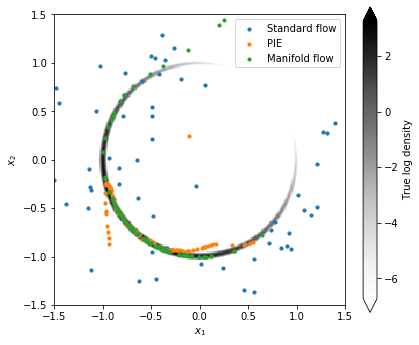

In [14]:
skip = 10
res = 250
x_range = np.linspace(-1.5,1.5,res)
y_range = np.linspace(-1.5,1.5,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
logp_grid = simulator.log_density(x_grid).reshape((res, res))
logp_grid[~np.isfinite(logp_grid)] = -1000000.
zmin, zmax = np.max(logp_grid) - 10., np.max(logp_grid)

fig = plt.figure(figsize=(6,5))
ax = plt.gca()

pcm = plt.imshow(
    np.clip(logp_grid, zmin, zmax),
    extent=(-1.5,1.5,-1.5,1.5),
    origin="lower",
    cmap="Greys",
    norm=matplotlib.colors.Normalize(zmin, zmax),
    interpolation='nearest'
)
cb = plt.colorbar(pcm, extend="both")

plt.scatter(x_gen_sf[::skip,0], x_gen_sf[::skip,1], s=10., c="C0", label="Standard flow")
plt.scatter(x_gen_pie[::skip,0], x_gen_pie[::skip,1], s=10., c="C1", label="PIE")
plt.scatter(x_gen_mf[::skip,0], x_gen_mf[::skip,1], s=10., c="C2", label="Manifold flow")

plt.legend()

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
cb.set_label("True log density")

plt.tight_layout()
plt.savefig("spherical_gaussian_2d_generation.pdf")


## Visualize learned likelihoods

### Log likelihood

In [15]:
res = 100
x_range = np.linspace(-1.5,1.5,res)
y_range = np.linspace(-1.5,1.5,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
x_grid_tensor = torch.FloatTensor(x_grid)

learned_logp_grid_mf = mf.log_prob(x_grid_tensor).detach().numpy().reshape((res, res))
learned_logp_grid_sf = sf.log_prob(x_grid_tensor).detach().numpy().reshape((res, res))
learned_logp_grid_pie = pie.log_prob(x_grid_tensor).detach().numpy().reshape((res, res))
logp_grid_truth = simulator.log_density(x_grid).reshape((res, res))
logp_grid_truth[~np.isfinite(logp_grid_truth)] = -1000000.


../../experiments/data_generation/spherical_simulator.py:99: RuntimeWarning: divide by zero encountered in log
  logp_eps = np.log(norm(loc=0.0, scale=self._epsilon).pdf(z_eps))


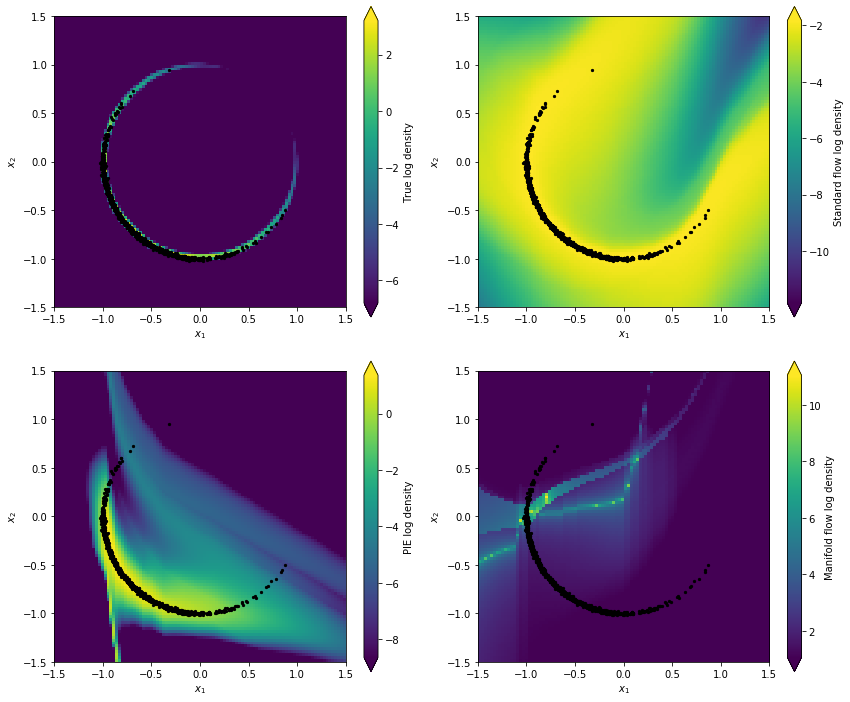

In [16]:
skip = 100

fig = plt.figure(figsize=(12,10))

for i, (label, logp) in enumerate(zip(
    ["True log density", "Standard flow log density", "PIE log density", "Manifold flow log density"],
    [logp_grid_truth, learned_logp_grid_sf, learned_logp_grid_pie, learned_logp_grid_mf]
     )):
    ax = plt.subplot(2,2,i+1)

    zmin, zmax = np.max(logp) - 10., np.max(logp)

    pcm = plt.imshow(
        np.clip(logp, zmin, zmax),
        extent=(-1.5, 1.5, -1.5, 1.5),
        origin="lower",
        cmap="viridis",
        norm=matplotlib.colors.Normalize(zmin, zmax),
        interpolation='nearest'
    )
    cb = plt.colorbar(pcm, extend="both")
    plt.scatter(x[::skip,0], x[::skip,1], s=5., c="black")

    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    cb.set_label(label)
    
plt.tight_layout()
plt.savefig("spherical_gaussian_2d_log_prob.pdf", dpi=600)


## More visualizations

### Reconstruction

In [ ]:
x_in = SphericalGaussianSimulator(1,2,epsilon=5*epsilon).sample(100)
x_in = torch.FloatTensor(x_in)
x_out = mf(x_in)[0]
x_in, x_out = x_in.detach().numpy(), x_out.detach().numpy()
dx = x_out - x_in

In [ ]:
fig = plt.figure(figsize=(5,5))
ax = plt.gca()
plt.scatter(x_in[:,0], x_in[:,1], s=15., c="C1")
plt.scatter(x_out[:,0], x_out[:,1], s=15., c="C0")
plt.quiver(
    x_in[:,0], x_in[:,1], dx[:,0], dx[:,1],
    angles='xy', scale_units='xy', scale=1., width=2.e-3, alpha=1.
)

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.tight_layout()

plt.savefig("spherical_gaussian_2d_reconstruction.pdf")


### Latent variables

In [ ]:
res = 51
x_range = np.linspace(-1.5,1.5,res)
y_range = np.linspace(-1.5,1.5,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
x_grid_tensor = torch.FloatTensor(x_grid)

_, _, u = mf(x_grid_tensor)
u = u.detach().numpy()


In [ ]:
zmin, zmax = np.min(u), np.max(u)
fig = plt.figure(figsize=(5,4))
ax = plt.gca()

pcm = plt.pcolormesh(
    x_range, y_range,
    np.clip(u.reshape(res, res), zmin, zmax),
    cmap="viridis", norm=matplotlib.colors.Normalize(zmin, zmax)
)
cb = plt.colorbar(pcm, extend="both")
plt.scatter(x_gen_mf[:,0], x_gen_mf[:,1], s=5., c="black")

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
cb.set_label("$\log \; \hat{p}(x)$")
plt.tight_layout()

plt.savefig("spherical_gaussian_2d_latent.pdf")